## DS 6003 Exercise 1: Full pipeline using Spark

Jing Sun (js6mj)

1/29/19

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from pyspark.ml.linalg import Vectors, VectorUDT
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# sources: 
# https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
# https://spark.apache.org/docs/2.1.0/mllib-evaluation-metrics.html
# https://www.kaggle.com/joniarroba/noshowappointments

### Creation of your context

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

### Preparation of data (get it into parquet)

In [3]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'js6mj/appointment.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
app = pd.read_csv(data_location)
app.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
app = app.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], axis=1)
app.dropna(inplace=True)

In [6]:
df = sqlc.createDataFrame(app)
df

DataFrame[Gender: string, Age: bigint, Neighbourhood: string, Scholarship: bigint, Hipertension: bigint, Diabetes: bigint, Alcoholism: bigint, Handcap: bigint, SMS_received: bigint, No-show: string]

In [7]:
parquetPath = '/home/ec2-user/SageMaker/js6mj/appointment-pqt'
df.write.parquet(parquetPath)

### MLlib based analysis

In [8]:
df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Neighbourhood: string (nullable = true)
 |-- Scholarship: long (nullable = true)
 |-- Hipertension: long (nullable = true)
 |-- Diabetes: long (nullable = true)
 |-- Alcoholism: long (nullable = true)
 |-- Handcap: long (nullable = true)
 |-- SMS_received: long (nullable = true)
 |-- No-show: string (nullable = true)



In [9]:
app.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [10]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['Gender','Neighbourhood']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol= categoricalCol + "classVec")
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'No-show', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [11]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [12]:
df.head()

Row(label=0.0, features=SparseVector(88, {0: 1.0, 4: 1.0, 81: 62.0, 83: 1.0}))

In [13]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 88434, test set N = 22093


#### Logistic Regression

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
lrModel = lr.fit(trainingDF)
predictions_lr = lrModel.transform(testDF)

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC (Logistic Regression): {:.3f}'.format(evaluator.evaluate(predictions_lr)))

Test Area Under ROC (Logistic Regression): 0.608


#### Decision Tree

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
dtModel = dt.fit(trainingDF)
predictions_dt = dtModel.transform(testDF)

In [17]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC (Decision Tree): {:.3f}'.format(evaluator.evaluate(predictions_dt)))

Test Area Under ROC (Decision Tree): 0.533


#### Gradient-boosted Tree

In [18]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier()
gbtModel = gbt.fit(trainingDF)
predictions_gbt = gbtModel.transform(testDF)

In [19]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC (Gradient-boosted tree): {:.3f}'.format(evaluator.evaluate(predictions_gbt)))

Test Area Under ROC (Gradient-boosted tree): 0.621


### Visualizations

Text(0.5,1,'Medical Appointment No-shows')

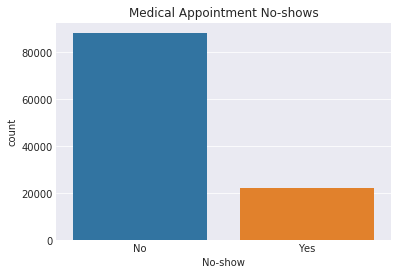

In [21]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
sns.countplot(app['No-show'])
plt.title('Medical Appointment No-shows')

Text(0.5,1,'Appointment show status for male and female')

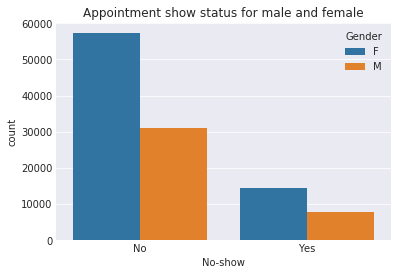

In [22]:
sns.countplot(x='No-show',hue='Gender',data=app)
plt.title('Appointment show status for male and female')

Text(0.5,1,'Percent of males and females')

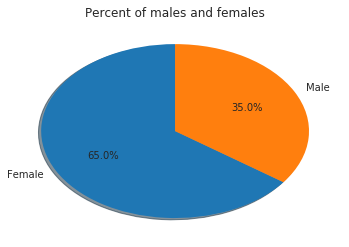

In [23]:
labels='Female','Male'
sizes=[13,7]
plt.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Percent of males and females")

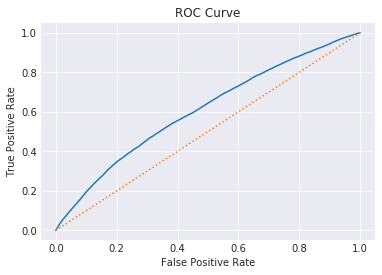

Training set areaUnderROC: 0.608


In [24]:
## logistic regression training set AUC
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.plot([0,1],linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: {:.3f}'.format(trainingSummary.areaUnderROC))